In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install truecase
!pip install seqeval
!pip install transformers
!pip install datasets

In [ ]:
import os

os.chdir("drive/MyDrive/Colab Notebooks/kcl_individual_project")

In [ ]:
import torch
import data_preprocess as dp
import comp_models as cm
from transformers import AutoTokenizer
import transformers

# Hyperparameters: Note that if the "MAX_LEN" below is changed, the "MAX_LEN" in comp_models.py must be the same as well.
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 5e-5

# load the tokenizer of bert-base-cased
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
# for conll2003
datasets = dp.load_conll("conll2003")

batch_size = 16
label_list1 = datasets["train"].features["pos_tags"].feature.names
label_list2 = datasets["train"].features["chunk_tags"].feature.names
label_list3 = datasets["train"].features["ner_tags"].feature.names
print(len(label_list1),len(label_list2),len(label_list3))

example = datasets["train"][4]
print(example["tokens"])
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)
word_ids = tokenized_input.word_ids()
aligned_labels1 = [-100 if i is None else example["pos_tags"][i] for i in word_ids]
aligned_labels2 = [-100 if i is None else example["chunk_tags"][i] for i in word_ids]
aligned_labels3 = [-100 if i is None else example["ner_tags"][i] for i in word_ids]
print(aligned_labels1)
print(aligned_labels2)
print(aligned_labels3)

train_data_loader, val_data_loader, test_data_loader = dp.preprocess_raw_dataset(tokenizer, "conll2003", datasets, BATCH_SIZE, MAX_LEN)

In [ ]:
# for conll2000
datasets = dp.load_conll("conll2000")

batch_size = 16
label_list1 = datasets["train"].features["pos_tags"].feature.names
label_list2 = datasets["train"].features["chunk_tags"].feature.names
print(len(label_list1),len(label_list2))

example = datasets["train"][4]
print(example["tokens"])
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)
word_ids = tokenized_input.word_ids()
aligned_labels1 = [-100 if i is None else example["pos_tags"][i] for i in word_ids]
aligned_labels2 = [-100 if i is None else example["chunk_tags"][i] for i in word_ids]
print(aligned_labels1)
print(aligned_labels2)

train_data_loader, test_data_loader = dp.preprocess_raw_dataset(tokenizer, "conll2000", datasets, BATCH_SIZE, MAX_LEN)
val_data_loader = []

In [ ]:
# for both of them --> only for both of the pos tasks
datasets03 = dp.load_conll("conll2003")
datasets00 = dp.load_conll("conll2000")
train_data_loader03, val_data_loader03, test_data_loader03 = dp.preprocess_raw_dataset(tokenizer, "conll2003", datasets03, BATCH_SIZE, MAX_LEN)
train_data_loader00, test_data_loader00 = dp.preprocess_raw_dataset(tokenizer, "conll2000", datasets00, BATCH_SIZE, MAX_LEN)

In [ ]:
datasets

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# the code for choosing which BERT composite model to use
# basically, pick a model and its checkpoint_path in one of the following 3 groups: MRN, MTL or STL
"""
Group 1
for MRN
"""
model = cm.BERT_MRN_conll2003()
# model = cm.BERT_MRN_conll2000()
# model = cm.BERT_MRN_BOTH_POS()
checkpoint_path = "bert_reg_checkpoints/MRN_conll2003_15_07"


"""
Group 2
for MTL
"""
# model = cm.BERT_MTL_conll2003()
# model = cm.BERT_MTL_conll2000()
# model = cm.BERT_MTL_BOTH_POS()
# checkpoint_path = "bert_no_reg_checkpoints/MTL_both_pos_0705_5percent"


"""
Group 3
for STL: need to specify the total number of distinct labels in the target task
for example, in the NER task in CONLL-03, num_labels is 9
"""
# num_labels = 9
# model = cm.BERT_STL(num_labels)
# checkpoint_path = "bert_base_checkpoints/STL_conll2003_0704_NER"

# attach the model to the target device (normally GPU)

"""
attach the model to the device
"""
model.to(device)
optimizer = torch.optim.AdamW(params = model.parameters(), lr=LEARNING_RATE)

In [ ]:
model

In [ ]:
# load the model from a checkpoint for evaluation
# model, optimizer, EPOCHS , avg_valid_loss = cm.load_model("bert_base_checkpoints/STL_conll2003_0704_NER", model, optimizer)
# model.to(device)

In [ ]:
# the code for training --> make sure the model is trained under the right learning paradigm with the right dataset
# for instance, train_conll2003_MRN() means that the model will be fine-tuned under MRN with CoNLL-03 dataset
# Note that train_STL() can be used for both of the datasets

import trainers as trainers
model = trainers.train_conll2003_MRN(EPOCHS, train_data_loader, val_data_loader, model, optimizer, checkpoint_path)
# model = trainers.train_conll2000_MRN(EPOCHS, train_data_loader, val_data_loader, model, optimizer, checkpoint_path)
# model = trainers.train_conll2003_MTL(EPOCHS, train_data_loader, val_data_loader, model, optimizer, checkpoint_path)
# model = trainers.train_conll2000_MTL(EPOCHS, train_data_loader, val_data_loader, model, optimizer, checkpoint_path)
# model = trainers.train_STL(EPOCHS, train_data_loader, val_data_loader, model, optimizer, checkpoint_path, num_labels, task="ner")
# model = trainers.train_both_pos_MRN(EPOCHS, 0.05, train_data_loader03, train_data_loader00, model, optimizer, checkpoint_path)
# model = trainers.train_both_pos_MTL(EPOCHS, 0.05, train_data_loader03, train_data_loader00, model, optimizer, checkpoint_path)

In [ ]:
# the code for testing --> make sure the model is tested under the right learning paradigm with the right dataset
# for instance, test_conll2003_MRN_or_MTL() means that the MRN or MTL model will be tested with CoNLL-03 dataset
# Note that test_STL() can be used for both of the datasets

import testers as testers
testers.test_conll2003_MRN_or_MTL(model, test_data_loader, datasets)
# testers.test_conll2000_MRN_or_MTL(model, test_data_loader, datasets)
# testers.test_STL(model, test_data_loader, datasets, task="ner")
# testers.test_both_pos_MRN_or_MTL(model, test_data_loader03, datasets03, test_data_loader00, datasets00)

base_identity_matrix:
task:
Covariance Matrix:
 tensor([[1.0002e-05, 6.8482e-11],
        [6.8482e-11, 1.0001e-05]])
Correlation Matrix:
 tensor([[1.0000e+00, 6.8472e-06],
        [6.8472e-06, 1.0000e+00]])
class:
Covariance Matrix:
 tensor([[ 6.4574e-11,  4.1285e-12,  1.2648e-12,  ...,  2.9073e-12,
          9.0211e-13, -1.4252e-12],
        [ 4.1285e-12,  6.9122e-11, -6.1758e-13,  ...,  3.4872e-13,
          2.0668e-13,  2.9911e-12],
        [ 1.2648e-12, -6.1758e-13,  6.4574e-11,  ...,  7.0439e-13,
         -3.3019e-13,  1.9307e-12],
        ...,
        [ 2.9073e-12,  3.4872e-13,  7.0439e-13,  ...,  3.3651e-11,
          3.1113e-12,  1.2307e-12],
        [ 9.0212e-13,  2.0668e-13, -3.3019e-13,  ...,  3.1113e-12,
          3.2742e-11,  1.9501e-13],
        [-1.4252e-12,  2.9911e-12,  1.9307e-12,  ...,  1.2307e-12,
          1.9501e-13,  3.3651e-11]])
Correlation Matrix:
 tensor([[ 1.0000,  0.0618,  0.0196,  ...,  0.0624,  0.0196, -0.0306],
        [ 0.0618,  1.0000, -0.0092,  ...,  

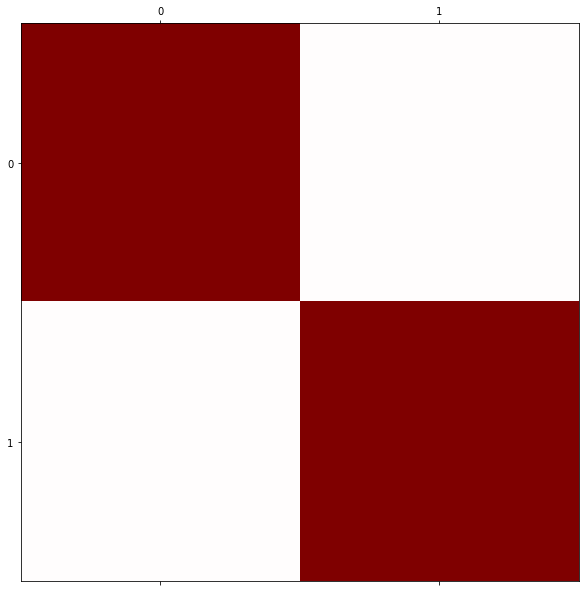

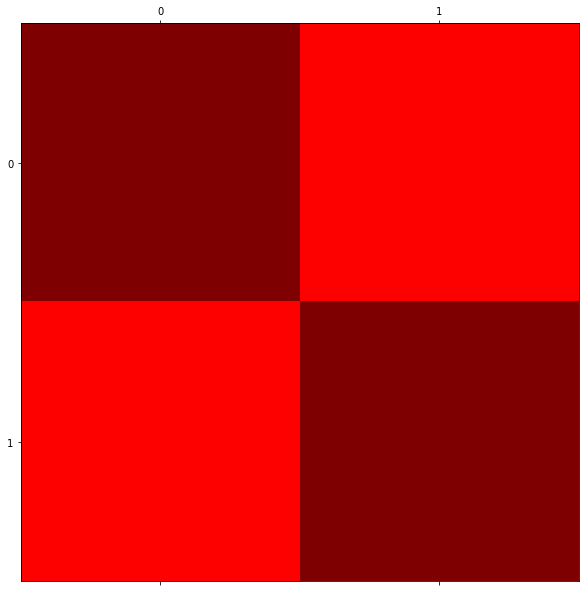

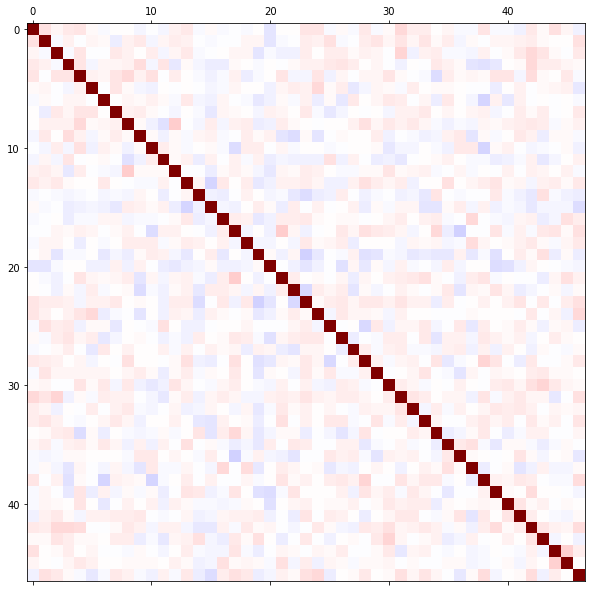

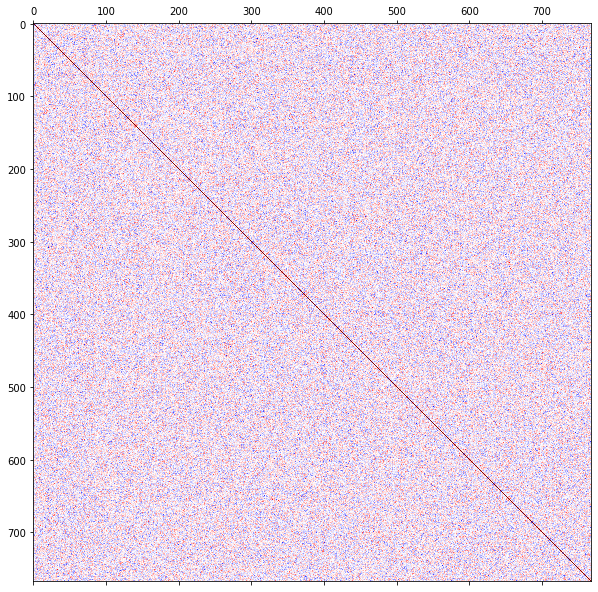

In [ ]:
# the code for visualization for the two POS tasks
%matplotlib inline               
import numpy as np
import matplotlib.pyplot as plt
def calculate_correlation(omega):
  print("Covariance Matrix:\n",omega)
  diag = torch.sqrt(torch.diag(torch.diag(omega)))
  gaid = torch.linalg.inv(diag)
  corr = gaid @ omega @ gaid
  print("Correlation Matrix:\n", corr)
  return corr
eps = 1e-5
w = trainers.weights_cat_both_pos(model.linear1.weight, model.linear2.weight)
temp_task_covariance = trainers.covariance_mat_update(w.data, model.class_covariance.data, model.feature_covariance.data)
temp_class_covariance = trainers.covariance_mat_update(w.data.permute(1, 0, 2), model.task_covariance.data, model.feature_covariance.data)
temp_feature_covariance = trainers.covariance_mat_update(w.data.permute(2, 0, 1), model.task_covariance.data, model.class_covariance.data)

print("base_identity_matrix:")
fig = plt.figure(figsize=(10,10))
plt.matshow(torch.eye(2), cmap=plt.get_cmap("seismic"), vmin=-1, vmax=1, fignum=fig.number)
print("task:")
task_fig = plt.figure(figsize=(10,10))
plt.matshow(calculate_correlation(temp_task_covariance.cpu().detach()-eps*torch.eye(2)), cmap=plt.get_cmap("seismic"), vmin=-3, vmax=1, fignum=task_fig.number)
print("class:")
class_fig = plt.figure(figsize=(10,10))
plt.matshow(calculate_correlation(temp_class_covariance.cpu().detach()-eps*torch.eye(47)), cmap=plt.get_cmap("seismic"), vmin=-1, vmax=1, fignum=class_fig.number)
print("feature:")
feature_fig = plt.figure(figsize=(10,10))
plt.matshow(calculate_correlation(temp_feature_covariance.cpu().detach()-eps*torch.eye(768)), cmap=plt.get_cmap("seismic"), vmin=-1, vmax=1, fignum=feature_fig.number)